# E-commerce Customer Purchase Prediction

This Notebook predicts Customer Purchase pattern based on online shoppers intention dataset.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import chi2_contingency, jarque_bera, normaltest
import itertools
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Target distribution:\n{df['Revenue'].value_counts()}")
print(f"Target percentage:\n{df['Revenue'].value_counts(normalize=True)*100}")

Dataset shape: (12330, 18)
Missing values: 0
Duplicate rows: 125
Target distribution:
Revenue
False    10422
True      1908
Name: count, dtype: int64
Target percentage:
Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64


# Data Overview

In [3]:
df.info()
print("\nNumerical columns statistics:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(df[numerical_cols].describe())

print("\nCategorical columns:")
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())
    print("-" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Data Quality Assessment

In [4]:
def data_quality_report(dataframe):
    report = {}
    for col in dataframe.columns:
        col_data = dataframe[col]
        report[col] = {
            'dtype': str(col_data.dtype),
            'missing_count': col_data.isnull().sum(),
            'missing_percentage': (col_data.isnull().sum() / len(col_data)) * 100,
            'unique_count': col_data.nunique(),
            'duplicate_count': col_data.duplicated().sum()
        }

        if col_data.dtype in ['int64', 'float64']:
            report[col].update({
                'mean': col_data.mean(),
                'std': col_data.std(),
                'min': col_data.min(),
                'max': col_data.max(),
                'skewness': col_data.skew(),
                'kurtosis': col_data.kurtosis(),
                'zeros_count': (col_data == 0).sum(),
                'outliers_iqr': len(col_data[(col_data < (col_data.quantile(0.25) - 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25)))) |
                                           (col_data > (col_data.quantile(0.75) + 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25))))])
            })

    return pd.DataFrame(report).T

quality_report = data_quality_report(df)
print("Data Quality Report:")
print(quality_report)

Data Quality Report:
                           dtype missing_count missing_percentage  \
Administrative             int64             0                0.0   
Administrative_Duration  float64             0                0.0   
Informational              int64             0                0.0   
Informational_Duration   float64             0                0.0   
ProductRelated             int64             0                0.0   
ProductRelated_Duration  float64             0                0.0   
BounceRates              float64             0                0.0   
ExitRates                float64             0                0.0   
PageValues               float64             0                0.0   
SpecialDay               float64             0                0.0   
Month                     object             0                0.0   
OperatingSystems           int64             0                0.0   
Browser                    int64             0                0.0   
Region       

# Visualization Dashboard - Distribution Analysis

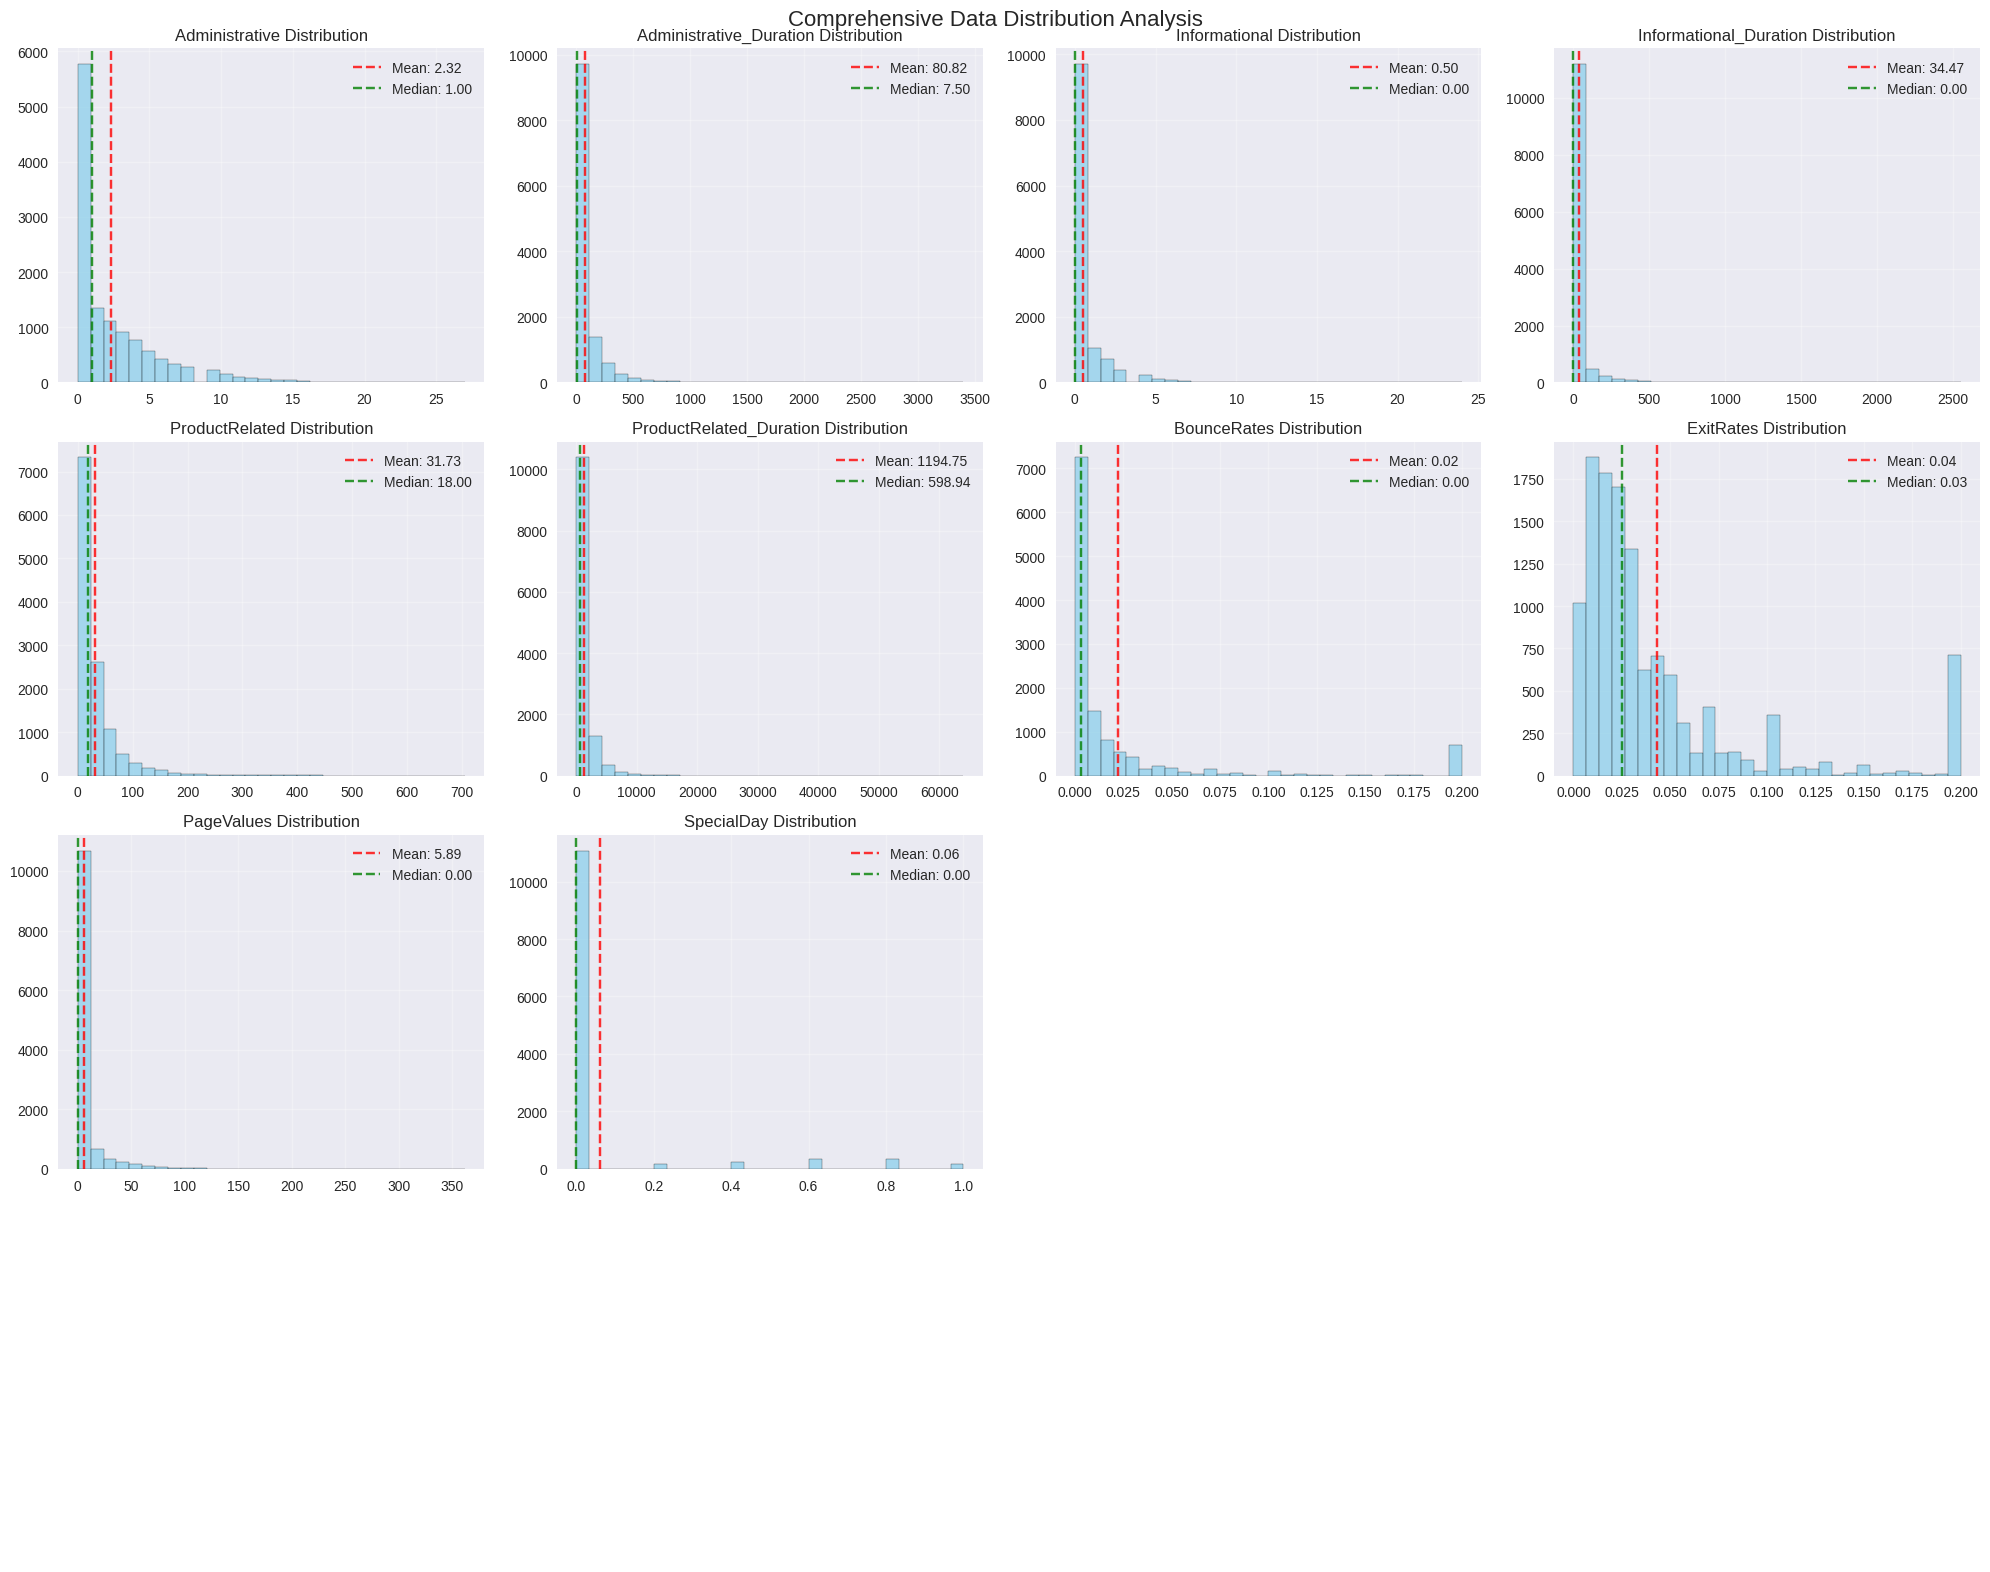

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Comprehensive Data Distribution Analysis', fontsize=16, y=0.98)

numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                     'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
                     'PageValues', 'SpecialDay']

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    axes[row, col].hist(df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].axvline(df[feature].mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {df[feature].mean():.2f}')
    axes[row, col].axvline(df[feature].median(), color='green', linestyle='--', alpha=0.8, label=f'Median: {df[feature].median():.2f}')
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

for i in range(len(numerical_features), 16):
    row, col = i // 4, i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Correlation Analysis and Heatmap

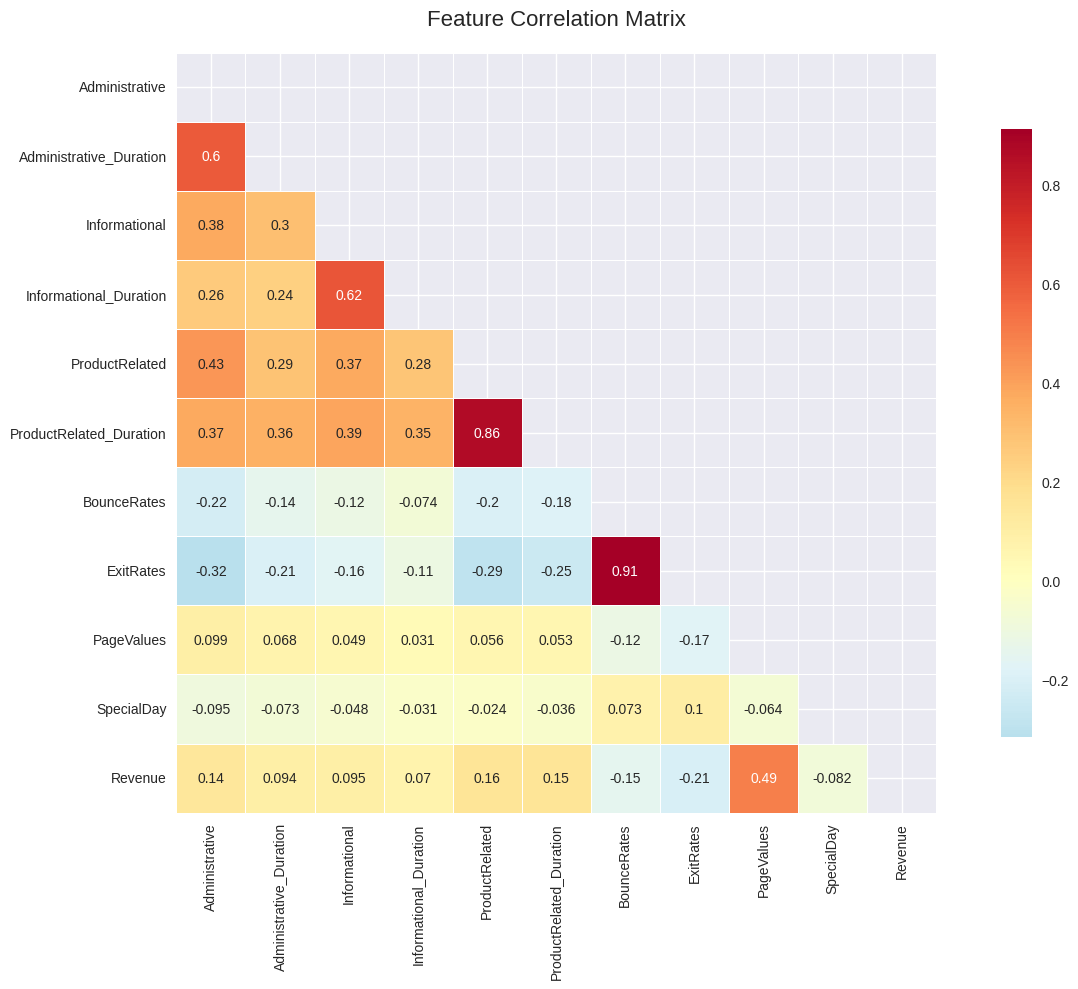

Strong correlations (|r| > 0.7):
ProductRelated <-> ProductRelated_Duration: 0.861
BounceRates <-> ExitRates: 0.913


In [6]:
correlation_matrix = df[numerical_features + ['Revenue']].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                     square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print("Strong correlations (|r| > 0.7):")
for pair in correlation_pairs:
    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

# Statistical Significance Testing

In [7]:
def perform_statistical_tests(dataframe, target_col):
    results = {}
    target = dataframe[target_col]

    for col in dataframe.select_dtypes(include=[np.number]).columns:
        if col != target_col:
            group_0 = dataframe[target == False][col]
            group_1 = dataframe[target == True][col]

            t_stat, t_pval = stats.ttest_ind(group_0, group_1)

            u_stat, u_pval = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')

            ks_stat, ks_pval = stats.ks_2samp(group_0, group_1)

            results[col] = {
                't_statistic': t_stat,
                't_pvalue': t_pval,
                'mannwhitney_statistic': u_stat,
                'mannwhitney_pvalue': u_pval,
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_pval
            }

    return pd.DataFrame(results).T

statistical_results = perform_statistical_tests(df, 'Revenue')
print("Statistical Test Results (p-values < 0.05 indicate significant differences):")
print(statistical_results.round(6))

Statistical Test Results (p-values < 0.05 indicate significant differences):
                         t_statistic  t_pvalue  mannwhitney_statistic  \
Administrative            -15.575194  0.000000              7421135.5   
Administrative_Duration   -10.436882  0.000000              7487115.0   
Informational             -10.618467  0.000000              8648742.0   
Informational_Duration     -7.829854  0.000000              8711649.0   
ProductRelated            -17.828190  0.000000              6792127.0   
ProductRelated_Duration   -17.118049  0.000000              6502463.0   
BounceRates                16.922638  0.000000             12198493.0   
ExitRates                  23.500777  0.000000             13981307.0   
PageValues                -62.843162  0.000000              2718419.0   
SpecialDay                  9.169515  0.000000             10665043.0   
OperatingSystems            1.628737  0.103394             10337403.0   
Browser                    -2.663779  0.007737 

# Feature Engineering

In [8]:
df_engineered = df.copy()

df_engineered['Revenue'] = df_engineered['Revenue'].astype(int)

df_engineered['Admin_Info_Interaction'] = df_engineered['Administrative'] * df_engineered['Informational']
df_engineered['Duration_Ratio'] = df_engineered['Administrative_Duration'] / (df_engineered['Informational_Duration'] + 1)
df_engineered['Product_Admin_Ratio'] = df_engineered['ProductRelated'] / (df_engineered['Administrative'] + 1)
df_engineered['Bounce_Exit_Interaction'] = df_engineered['BounceRates'] * df_engineered['ExitRates']
df_engineered['Page_Value_Per_Product'] = df_engineered['PageValues'] / (df_engineered['ProductRelated'] + 1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = ['BounceRates', 'ExitRates', 'PageValues']
for feature in poly_features:
    df_engineered[f'{feature}_squared'] = df_engineered[feature] ** 2
    df_engineered[f'{feature}_cubed'] = df_engineered[feature] ** 3
    df_engineered[f'{feature}_log'] = np.log1p(df_engineered[feature])
    df_engineered[f'{feature}_sqrt'] = np.sqrt(df_engineered[feature])

df_engineered['Total_Duration'] = (df_engineered['Administrative_Duration'] +
                                  df_engineered['Informational_Duration'] +
                                  df_engineered['ProductRelated_Duration'])
df_engineered['Avg_Duration_Per_Page'] = df_engineered['Total_Duration'] / (df_engineered['Administrative'] +
                                                                           df_engineered['Informational'] +
                                                                           df_engineered['ProductRelated'] + 1)
df_engineered['Session_Quality_Score'] = (df_engineered['PageValues'] / (df_engineered['BounceRates'] + 0.001)) * (1 - df_engineered['ExitRates'])

month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_engineered['Month_Numeric'] = df_engineered['Month'].map(month_mapping)

categorical_features = ['Month', 'VisitorType', 'Weekend']
df_encoded = pd.get_dummies(df_engineered, columns=categorical_features, drop_first=True)

print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_encoded.shape[1]}")
print("New features created:")
new_features = [col for col in df_encoded.columns if col not in df.columns]
print(new_features)

Original features: 18
Engineered features: 48
New features created:
['Admin_Info_Interaction', 'Duration_Ratio', 'Product_Admin_Ratio', 'Bounce_Exit_Interaction', 'Page_Value_Per_Product', 'BounceRates_squared', 'BounceRates_cubed', 'BounceRates_log', 'BounceRates_sqrt', 'ExitRates_squared', 'ExitRates_cubed', 'ExitRates_log', 'ExitRates_sqrt', 'PageValues_squared', 'PageValues_cubed', 'PageValues_log', 'PageValues_sqrt', 'Total_Duration', 'Avg_Duration_Per_Page', 'Session_Quality_Score', 'Month_Numeric', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_True']


# Exploratory Data Analysis Dashboard


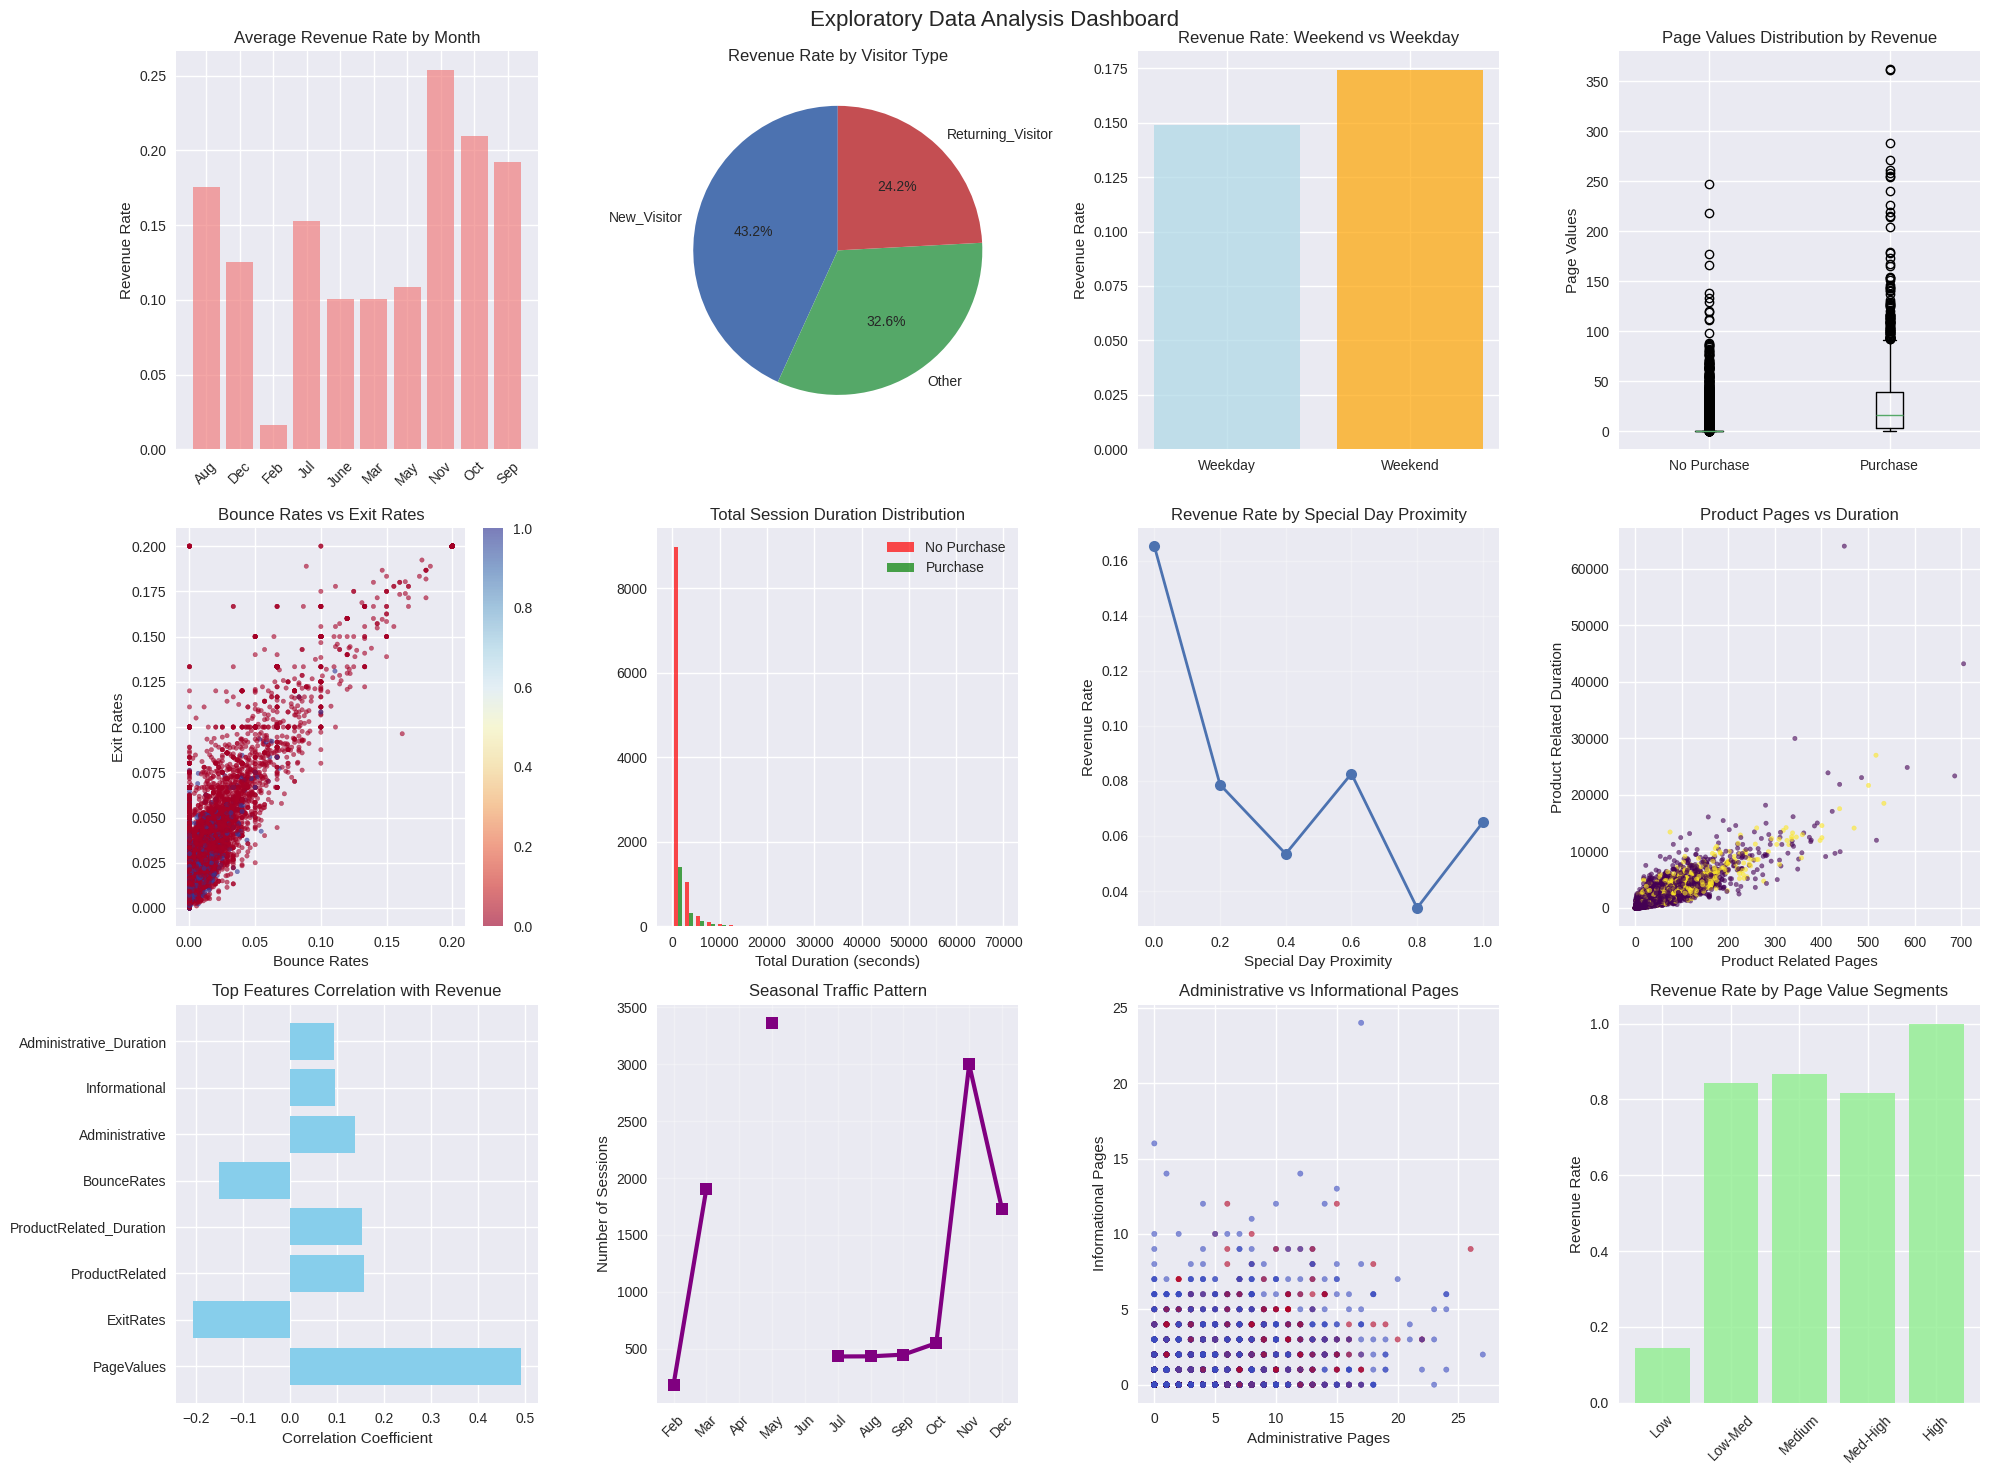

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Exploratory Data Analysis Dashboard', fontsize=16, y=0.98)

month_revenue = df.groupby('Month')['Revenue'].agg(['count', 'sum', 'mean']).reset_index()
axes[0, 0].bar(month_revenue['Month'], month_revenue['mean'], color='lightcoral', alpha=0.7)
axes[0, 0].set_title('Average Revenue Rate by Month')
axes[0, 0].set_ylabel('Revenue Rate')
axes[0, 0].tick_params(axis='x', rotation=45)

visitor_revenue = df.groupby('VisitorType')['Revenue'].mean()
axes[0, 1].pie(visitor_revenue.values, labels=visitor_revenue.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Revenue Rate by Visitor Type')

weekend_stats = df.groupby('Weekend')['Revenue'].agg(['count', 'sum', 'mean'])
x_pos = np.arange(len(weekend_stats))
axes[0, 2].bar(x_pos, weekend_stats['mean'], color=['lightblue', 'orange'], alpha=0.7)
axes[0, 2].set_title('Revenue Rate: Weekend vs Weekday')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(['Weekday', 'Weekend'])
axes[0, 2].set_ylabel('Revenue Rate')

axes[0, 3].boxplot([df[df['Revenue']==False]['PageValues'], df[df['Revenue']==True]['PageValues']],
                   labels=['No Purchase', 'Purchase'])
axes[0, 3].set_title('Page Values Distribution by Revenue')
axes[0, 3].set_ylabel('Page Values')

scatter = axes[1, 0].scatter(df['BounceRates'], df['ExitRates'], c=df['Revenue'],
                            cmap='RdYlBu', alpha=0.6, s=10)
axes[1, 0].set_title('Bounce Rates vs Exit Rates')
axes[1, 0].set_xlabel('Bounce Rates')
axes[1, 0].set_ylabel('Exit Rates')
plt.colorbar(scatter, ax=axes[1, 0])

session_duration = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
axes[1, 1].hist([session_duration[df['Revenue']==False], session_duration[df['Revenue']==True]],
                bins=30, alpha=0.7, label=['No Purchase', 'Purchase'], color=['red', 'green'])
axes[1, 1].set_title('Total Session Duration Distribution')
axes[1, 1].set_xlabel('Total Duration (seconds)')
axes[1, 1].legend()

special_day_revenue = df.groupby('SpecialDay')['Revenue'].mean()
axes[1, 2].plot(special_day_revenue.index, special_day_revenue.values, marker='o', linewidth=2, markersize=8)
axes[1, 2].set_title('Revenue Rate by Special Day Proximity')
axes[1, 2].set_xlabel('Special Day Proximity')
axes[1, 2].set_ylabel('Revenue Rate')
axes[1, 2].grid(True, alpha=0.3)

axes[1, 3].scatter(df['ProductRelated'], df['ProductRelated_Duration'],
                  c=df['Revenue'], cmap='viridis', alpha=0.6, s=10)
axes[1, 3].set_title('Product Pages vs Duration')
axes[1, 3].set_xlabel('Product Related Pages')
axes[1, 3].set_ylabel('Product Related Duration')

top_features = correlation_matrix['Revenue'].abs().sort_values(ascending=False)[1:9].index
corr_subset = df[list(top_features) + ['Revenue']].corr()['Revenue'][:-1]
axes[2, 0].barh(range(len(corr_subset)), corr_subset.values, color='skyblue')
axes[2, 0].set_yticks(range(len(corr_subset)))
axes[2, 0].set_yticklabels(corr_subset.index)
axes[2, 0].set_title('Top Features Correlation with Revenue')
axes[2, 0].set_xlabel('Correlation Coefficient')

monthly_sessions = df.groupby('Month').size()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sessions_ordered = monthly_sessions.reindex(month_order)
axes[2, 1].plot(monthly_sessions_ordered.index, monthly_sessions_ordered.values,
                marker='s', linewidth=3, markersize=8, color='purple')
axes[2, 1].set_title('Seasonal Traffic Pattern')
axes[2, 1].set_ylabel('Number of Sessions')
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].scatter(df['Administrative'], df['Informational'],
                  c=df['Revenue'], cmap='coolwarm', alpha=0.6, s=15)
axes[2, 2].set_title('Administrative vs Informational Pages')
axes[2, 2].set_xlabel('Administrative Pages')
axes[2, 2].set_ylabel('Informational Pages')

df['Behavior_Segment'] = pd.cut(df['PageValues'], bins=5, labels=['Low', 'Low-Med', 'Medium', 'Med-High', 'High'])
segment_revenue = df.groupby('Behavior_Segment')['Revenue'].mean()
axes[2, 3].bar(segment_revenue.index, segment_revenue.values, color='lightgreen', alpha=0.8)
axes[2, 3].set_title('Revenue Rate by Page Value Segments')
axes[2, 3].set_ylabel('Revenue Rate')
axes[2, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Preprocessing Pipeline Setup

In [10]:
X = df_encoded.drop(['Revenue'], axis=1)
y = df_encoded['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test.value_counts(normalize=True)}")

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'QuantileTransformer': QuantileTransformer(n_quantiles=1000, random_state=42)
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

print("Preprocessing completed with multiple scaling strategies")

Training set shape: (9864, 47)
Test set shape: (2466, 47)
Training set class distribution:
Revenue
0    0.845296
1    0.154704
Name: proportion, dtype: float64
Test set class distribution:
Revenue
0    0.845093
1    0.154907
Name: proportion, dtype: float64
Preprocessing completed with multiple scaling strategies


# Feature Selection and Dimensionality Analysis

Feature selection completed:
univariate: 20 features selected
rfe: 20 features selected
mutual_info: 20 features selected


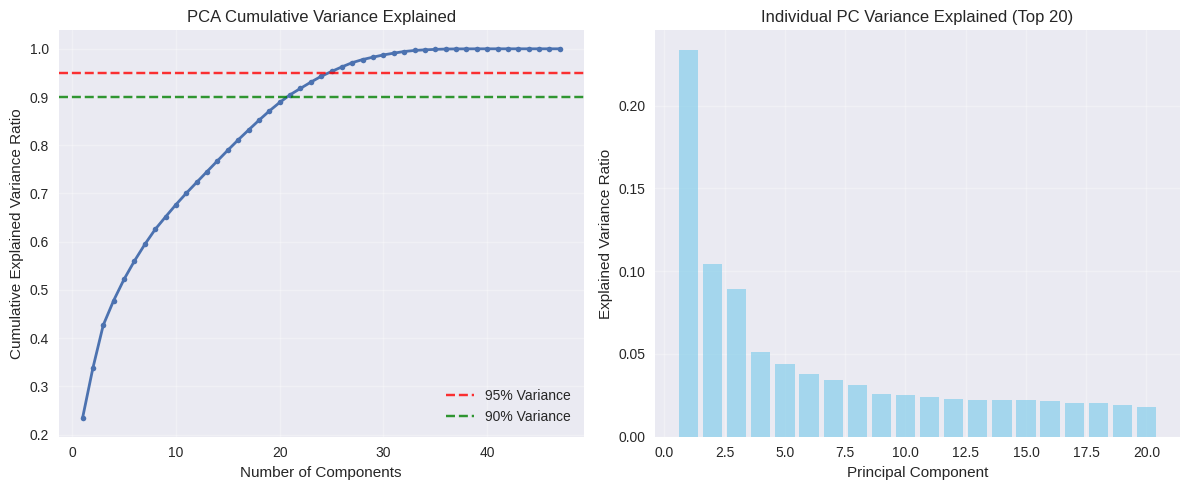

Number of components for 95% variance: 25


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

for scaler_name in scaled_data:
    scaled_data[scaler_name]['X_train'] = imputer.fit_transform(scaled_data[scaler_name]['X_train'])
    scaled_data[scaler_name]['X_test'] = imputer.transform(scaled_data[scaler_name]['X_test'])


feature_selectors = {}

selector_univariate = SelectKBest(score_func=f_classif, k=20)
X_train_univariate = selector_univariate.fit_transform(X_train_imputed, y_train)
X_test_univariate = selector_univariate.transform(X_test_imputed)
feature_selectors['univariate'] = {
    'selector': selector_univariate,
    'X_train': X_train_univariate,
    'X_test': X_test_univariate,
    'selected_features': X_train_imputed.columns[selector_univariate.get_support()].tolist()
}

rfe_selector = RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=20)
X_train_rfe = rfe_selector.fit_transform(X_train_imputed, y_train)
X_test_rfe = rfe_selector.transform(X_test_imputed)
feature_selectors['rfe'] = {
    'selector': rfe_selector,
    'X_train': X_train_rfe,
    'X_test': X_test_rfe,
    'selected_features': X_train_imputed.columns[rfe_selector.get_support()].tolist()
}

mi_scores = mutual_info_classif(X_train_imputed, y_train, random_state=42)
mi_top_features = X_train_imputed.columns[np.argsort(mi_scores)[-20:]].tolist()
feature_selectors['mutual_info'] = {
    'X_train': X_train_imputed[mi_top_features],
    'X_test': X_test_imputed[mi_top_features],
    'selected_features': mi_top_features
}

print("Feature selection completed:")
for method, data in feature_selectors.items():
    print(f"{method}: {len(data['selected_features'])} features selected")

pca = PCA()
pca.fit(scaled_data['StandardScaler']['X_train'])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2, markersize=4)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.8, label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', alpha=0.8, label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca.explained_variance_ratio_[:20], alpha=0.7, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual PC Variance Explained (Top 20)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_components_95}")

# Model Definition and Hyperparameter Grids

In [12]:
models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga'],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'criterion': ['gini', 'entropy'],
            'max_features': [None, 'sqrt', 'log2']
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'solver': ['adam', 'lbfgs']
        }
    }
}

print(f"Configured {len(models_config)} models for hyperparameter tuning")
print("Models:", list(models_config.keys()))

Configured 8 models for hyperparameter tuning
Models: ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVM', 'KNN', 'DecisionTree', 'MLP']
